<a href="https://colab.research.google.com/github/S3688570/Assignment2/blob/master/cars_transfer_learning_feat_extract_with_data_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN model of vehicle recognition - Feature extraction with data augmentation

In [75]:
from google.colab import drive, files
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My\ Drive/Colab\ Notebooks/'
!rsync -ah --progress\
    {gdrive_path}cars_dl/*.zip\
    {gdrive_path}model_weights_final*.h5\
    {gdrive_path}model_struct_final*.json\
    '/content'
!unzip -qo '*.zip'
!rm *.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
sending incremental file list
cars-20191002T050118Z-001.zip
        490.68M 100%  148.40MB/s    0:00:03 (xfr#1, to-chk=2/3)
model_struct_final.json
          5.33K 100%   10.08kB/s    0:00:00 (xfr#2, to-chk=1/3)
model_weights_final.h5
          1.33M 100%    1.30MB/s    0:00:00 (xfr#3, to-chk=0/3)


In [0]:
# Load Keras' VGG16 model that was pre-trained against the ImageNet database
from keras.applications import VGG16  #VGG16 model previously trained on very large ImageNet dataset.
conv_base = VGG16(weights='imagenet', #VGG16 weights
include_top=False,                    #Whether to include the densely connected classifier on top of the network.
input_shape=(128, 128, 3))            #Shape of image tensor fed to the network.

##Add densely connected classifier on top of VGG16 convolutional base

In [0]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [78]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## Freezing the convolutional base

In [79]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [80]:
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [0]:
import numpy as np
import matplotlib.pyplot as plt

#Method to print several images in a single row 
def plots(img, figsize=(12,6), rows = 1, titles = 1):
    if type(img[0]) is np.ndarray:
        img = np.array(img).astype(np.float_)
        if (img.shape[-1] != 3):
            img = img.transpose((0, 2, 3, 1))
    f =plt.figure(figsize = figsize)
    cols = 7//rows if (len(img) % 2 == 0) else len(img)//rows + 1
    for i in range(cols):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 10)
        plt.imshow(img[i], interpolation = None if np.interp else 'none')

In [82]:
import os

trainingCarImages = os.listdir('cars/training_set/car/')
print ("Number of Training car images - ",str(len(trainingCarImages)))

trainingCrashImages = os.listdir('cars/training_set/crash/')
print ("Number of Training crash images - ",str(len(trainingCrashImages)))

validCarImages = os.listdir('cars/val_set/car/')
print ("Number of Validation car images - ",str(len(validCarImages)))

validCrashImages = os.listdir('cars/val_set/crash/')
print ("Number of Validation crash images - ",str(len(validCrashImages)))

testCarImages = os.listdir('cars/test_set/car/')
print ("Number of Test car images - ",str(len(testCarImages)))

testCrashImages = os.listdir('cars/test_set/crash/')
print ("Number of Test crash images - ",str(len(testCrashImages)))

train_data_dir = 'cars/training_set/'
validation_data_dir = 'cars/val_set/'
test_data_dir = 'cars/test_set/'
nb_train_samples = trainingCarImages + trainingCrashImages
nb_validation_samples = validCarImages + validCrashImages
nb_test_samples = testCarImages + testCrashImages

Number of Training car images -  1445
Number of Training crash images -  1445
Number of Validation car images -  375
Number of Validation crash images -  372
Number of Test car images -  129
Number of Test crash images -  131


## Training the model end-to-end with a frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [84]:
training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 seed=42)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_set = test_datagen.flow_from_directory(validation_data_dir,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=True,
                                            seed=42)

test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=True,
                                            seed=42)


Found 2890 images belonging to 2 classes.
Found 747 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


## Print normalized and re-sized images from training set

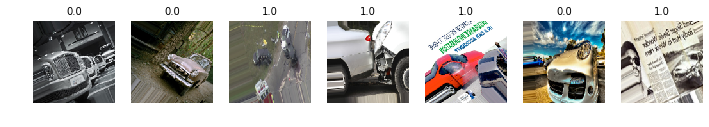

In [85]:
imgs, labels = next(training_set)
plots(imgs, titles = labels)

## Print normalized and re-sized images from validation set

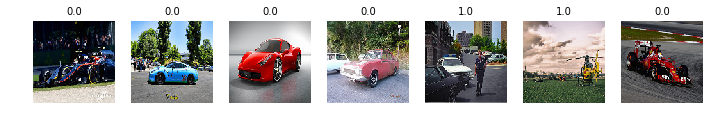

In [86]:
imgs, labels = next(val_set)
plots(imgs, titles = labels)

## Compile model

In [0]:
from keras import optimizers
model.compile(optimizer = optimizers.RMSprop(lr=2e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
#Method to identify and remove corrupted images
def my_gen(gen):
    while True:
        try:
            imgs, labels = next(gen)
            yield imgs, labels
        except:
            pass

## Train model

In [89]:
history = model.fit_generator(my_gen(training_set),
                         steps_per_epoch = 78,
                         epochs = 50,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/50
36/78 [============>.................] - ETA: 18s - loss: 0.6475 - acc: 0.6432

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


78/78 [==============================] - 46s 595ms/step - loss: 0.6081 - acc: 0.6879 - val_loss: 0.5236 - val_acc: 0.7901
Epoch 2/50
78/78 [==============================] - 41s 520ms/step - loss: 0.5336 - acc: 0.7505 - val_loss: 0.4844 - val_acc: 0.7792
Epoch 3/50
78/78 [==============================] - 40s 512ms/step - loss: 0.4818 - acc: 0.7759 - val_loss: 0.4534 - val_acc: 0.8042
Epoch 4/50
78/78 [==============================] - 40s 511ms/step - loss: 0.4660 - acc: 0.7988 - val_loss: 0.4447 - val_acc: 0.8010
Epoch 5/50
78/78 [==============================] - 40s 511ms/step - loss: 0.4414 - acc: 0.8004 - val_loss: 0.4143 - val_acc: 0.8293
Epoch 6/50
78/78 [==============================] - 39s 497ms/step - loss: 0.4497 - acc: 0.8031 - val_loss: 0.4377 - val_acc: 0.8222
Epoch 7/50
78/78 [==============================] - 40s 511ms/step - loss: 0.4279 - acc: 0.8122 - val_loss: 0.4262 - val_acc: 0.8081
Epoch 8/50
78/78 [==============================] - 39s 498ms/step - loss: 0.423

Exception ignored in: <generator object my_gen at 0x7fcfd3c48e60>
RuntimeError: generator ignored GeneratorExit


In [90]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


## Save neural network structure

In [91]:
from pathlib import Path
import os
transferModelFeatExtractDataAug_structure = model.to_json()
f = Path("transferModelFeatExtractDataAug_structure.json")
f.write_text(transferModelFeatExtractDataAug_structure)


11815

## Save neural network's trained weights

In [0]:
# Save neural network's trained weights
model.save_weights("transferModelFeatExtractDataAug_weights.h5")
model.save('transferModelFeatExtractDataAug_weights.h5')

## Plot training and validation accuracy per epoch

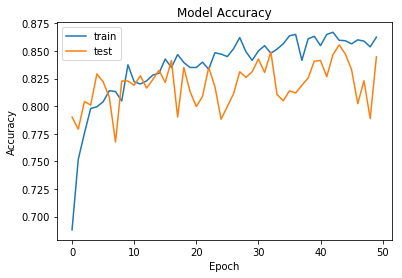

In [93]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Plot training and validation loss per epoch

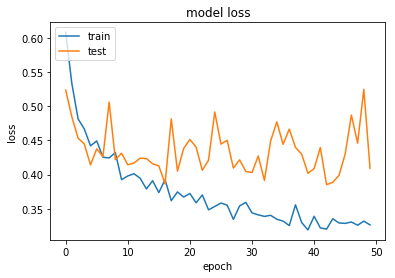

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

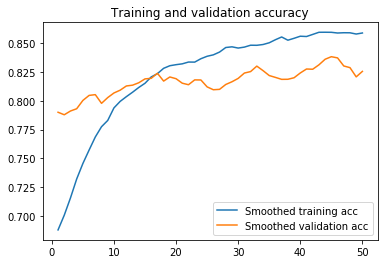

<Figure size 432x288 with 0 Axes>

In [95]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = range(1, len(acc) + 1)
  
plt.plot(epoch, smooth_curve(acc), 'tab:blue', label='Smoothed training acc')
plt.plot(epoch, smooth_curve(val_acc), 'tab:orange', label='Smoothed validation acc') 
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.figure()

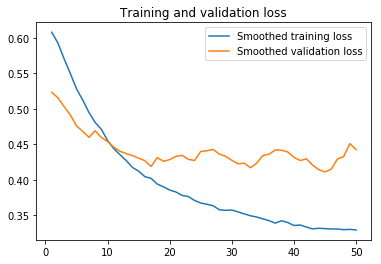

In [96]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, smooth_curve(loss), 'tab:blue', label='Smoothed training loss')
plt.plot(epoch, smooth_curve(val_loss), 'tab:orange', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()